# 🗺️**Understanding Sustainable Development Goals through maps**  
## Exploring the role of map generalisation

The aim of this Notebook is to present some **map generalization techniques** (i.e. transforming the cartographic representation of entities to reduce map complexity), which are essential when mapping a phenomenon at different scales. 
- Most of the techniques presented are based on **CartAGen**, which is :

    - an **open source Python library** made by **IGN** (i.e the french national mapping agency) researchers
    - a tool to carry out cartographic generalization processes and **automate** them
    - a **QGIS plugin** to use the Python library in a GIS environment 

- 🔗 **Useful links** : 
    - [Library repository](https://github.com/LostInZoom/cartagen4py?tab=readme-ov-file) 
    - [QGIS Plugin](https://plugins.qgis.org/plugins/cartagen4qgis/#plugin-details)
    - [CartAGen documentation](https://cartagen.readthedocs.io/en/latest/)
    - [UN Sustainable Development Goals](https://sdgs.un.org/goals)

_by Paul Bourcier, 2025 - EUPL 1.2_ 

## ⚙️ **Part 0 :** Preparing the working environment

In [ ]:
# Importing libraries

import cartagen as cg # the main library, containing cartographic generalization algorithms

#geographic data manipulation 
import geopandas as gp # used to import and manipulate geographic data

#displaying the data
from matplotlib import pyplot as plt # for ploting results, especially maps
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar # adding scalebar to the maps
#import matplotlib.colors as matcol # generating color palettes
#from matplotlib.path import Path  # Plot generation
#from matplotlib.patches import PathPatch # Plot generation
#from mpl_toolkits.axisartist.axislines import Subplot # Plot generation
#import matplotlib.colors as mcolors #generating colors 
#import matplotlib.cm as cm #used to display colorbar
import contextily as ctx # Adding basemaps
import mapclassify # Choropletes maps

#creating interactive outputs
import ipywidgets # creation of interactive plots
#import pydeck as pdk #deck.gl in Python for interactive maps
#import json #manipulating dictionnaries
#import ipyleaflet #creates interactive maps

# other data manipulation
#import pandas as pd # used to concatenate datas
import numpy as np # Using mathematical operations in Python
#from sklearn import cluster #clustering methods

import warnings # Remove warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Numba not installed. Using slow pure python version.") # Remove user warning 


## 📈 **Part 1 :** Maps and SDGs : the example of the Gini index

🧠 To understand the SDGs and how to achieve it, one must understand some **indicators**. Let's take the example of SDG n°10 : _"Reduce inequality within and among countries"_.

The **Gini index** is a key indicator for understanding this objective, as it measures the way in which a **resource** (notably disposable income) is **distributed** among the inhabitants of a country or region. It ranges from **0** (perfect equality) to **1** (no equality).

Gini index is derived from the **Lorenz's cruve**. Before diving into maps, let's take a closer look to it.

### **1.1** Gini index and Lorenz curve principle

The code used in this part does mainly come from this [webpage](https://zhiyzuo.github.io/Plot-Lorenz/)

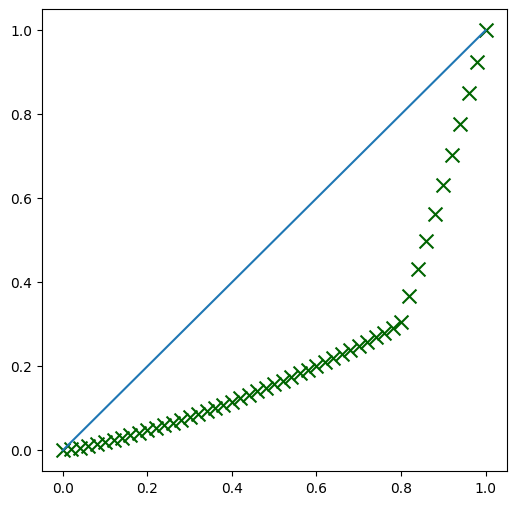

In [2]:
# First, retrieve all the income of a population. Here we build an artificial value sample, representing our income.
income = np.array([2, 10, 24, 4, 7, 800, 56, 32, 1, 5, 46, 78, 336])  
# Let's populate our array of value thanks to numpy functions, as it enable to get a bigger sample more quickly
income = np.append(np.random.poisson(lam=10, size=40), np.random.poisson(lam=100, size=10)) #here we use Poisson random to draw. We could use another function

# Secondly, we must sort our income, from lowest to highest
income = np.sort(income)

# Thirdly, we convert our values into cummulated proportions
income = income.cumsum() / income.sum()
# we then had 0 as our first value
income = np.insert(income,0,0)

# We now compute the cummulated proportions of people/household in our population
pop = np.arange(income.size)/(income.size-1)

# Finally, we can display the Lorenz cruve, that shows the distribution of income by the population
fig, ax = plt.subplots(figsize=[6,6])
ax.scatter(pop , income, marker='x', color='darkgreen', s=100)
## We had a line representing perfect equality
ax.plot([0,1], [0,1])


📈 The x axis represent the **cummulated proportion of household** (sorted by income) while the y axis shows the **cummulated proportion of the income**. In this situation, approximatly **80%** of the poorest holds less than **30%** of the income, which is a clear inequality. On the contrary, the straight line is showing the **perfect equality situation**, were **80%** of the poorest holds **80%** of the income.

The Gini index correspond to the area between the Lorenz curve and the straight line representing perfect equality. It is also possible to compute it with this formula :
$$
Gini = \frac{2 \sum_{i=1}^{n} i \times y_i}{n \sum_{i=1}^{n} y_i} - \frac{n + 1}{n}
$$
A weighted sum of the income is divided by the sum of the income, and normalized by substracting a constant. 

In [3]:
# Let's compute the Gini index of our first example
coef_ = 2. / income.size #numerator part 1
weighted_sum = sum([(i+1)*yi for i, yi in enumerate(income)]) #numerator part 2
const_ = (income.size + 1.) / income.size #constant

gini = coef_*weighted_sum/(income.sum()) - const_
print("Gini index : " + str(gini))

Gini index : 0.5301779245373506


Here an animation to seize the effect on Lorenz curve on Gini index

In [4]:
def plt_gini_lorenz(income_diff):
    incm = np.append(np.random.poisson(lam=10, size=50), np.random.poisson(lam=income_diff, size=50))
    incm = np.sort(incm)
    incm = incm.cumsum() / incm.sum()
    incm = np.insert(incm,0,0)
    popu = np.arange(incm.size)/(incm.size-1)

    gini = (2. / incm.size)*sum([(i+1)*yi for i, yi in enumerate(incm)])/(incm.sum()) - ((incm.size + 1.) / incm.size) 

    fig, ax = plt.subplots(figsize=[6,6])
    ax.scatter(popu , incm, marker='x', color='darkgreen', s=100) 
    ax.plot([0,1], [0,1], color='k')
    ax.text(0.35, 0.8, f'Gini index : {round(gini,2)}', fontsize=12, color='red', ha='right')


ipywidgets.interact(plt_gini_lorenz, income_diff = (0, 100, 1))

interactive(children=(IntSlider(value=50, description='income_diff'), Output()), _dom_classes=('widget-interac…

<function __main__.plt_gini_lorenz(income_diff)>

### **1.2** Spatializing the Gini index

As a powerful indicator to measure inequalities, the Gini index is relevant to compare situations between countries.

Maps are well suited to quickly perform that comparison, by spatializing the index.

Text(0.5, 1.0, 'Gini index in the world countries\n')

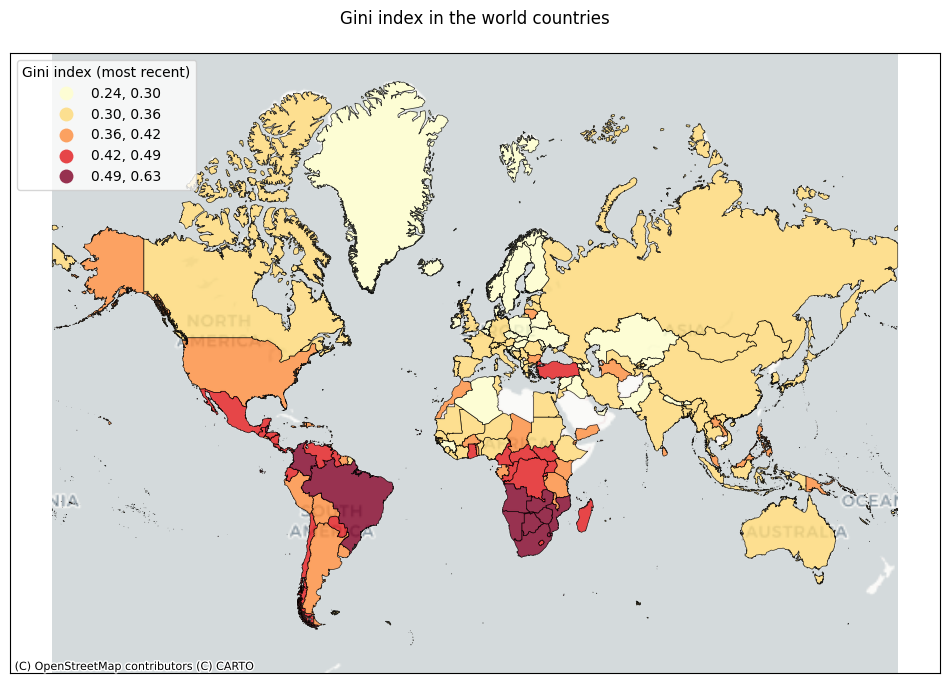

In [ ]:
# Create a simple choroplete map and display it
gini_world = gp.read_file("data/gini_world.geojson") #load the data (i.e world country with an 'gini_index' column)

ax = gini_world.plot(linewidth=0.5, zorder = 1, cmap = 'YlOrRd',
                     edgecolor = 'black', column = 'gini_index', legend = True,
                     alpha = 0.8, scheme='FisherJenks',
                     legend_kwds ={'loc':'upper left','title': 'Gini index (most recent)'}, figsize= (12,12)) # thematic layer

# optional elements
ax.axes.get_xaxis().set_visible(False) #remove x axis
ax.axes.get_yaxis().set_visible(False) #remove y axis

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron) #basemap
plt.title('Gini index in the world countries\n') #title

This map enables a quick comparison of the Gini index **between countries**. But the issue of inequalities not only arise at **national level**. 

When showing the spatiality of a phenomenon at different **scales**, cartographers have two options :
- producing several maps at each chosen scale (**atlas**)
- creating a map that encompass every desired scale (**multi-scale map**)

In this Notebook, we chose the second options

### **1.3** Gini index at local scale

In this section, we will use the data of the INSEE (french statistics institute), which provide Gini indexes at a sub-municipal level.